In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
print(locale.getpreferredencoding())

UTF-8


In [3]:
iou_type = 'siou'  # Assign a value to iou_type

if iou_type == 'iou':
    print("Using IOU")
elif iou_type == 'siou':
    print("Using SIOU")
else:
    print("Unknown IOU type")
    # ... (Rest of your SIoU Loss calculation code) ...
    # SIoU Loss https://arxiv.org/pdf/2205.12740.pdf
    iou = 0.0
    # Initialize iou with an initial value
    s_cw = (b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5  # 真实框和预测框中心点的宽度差
    s_ch = (b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5  # 真实框和预测框中心点的高度差
    sigma = torch.pow(s_cw ** 2 + s_ch ** 2, 0.5)  # 真实框和预测框中心点的距离
    sin_alpha_1 = torch.abs(s_cw) / sigma  # 真实框和预测框中心点的夹角β
    sin_alpha_2 = torch.abs(s_ch) / sigma  # 真实框和预测框中心点的夹角α
    threshold = pow(2, 0.5) / 2  # 夹角阈值
    sin_alpha = torch.where(sin_alpha_1 > threshold, sin_alpha_2, sin_alpha_1)  # α大于45°则考虑优化β，否则优化α
    angle_cost = torch.cos(torch.arcsin(sin_alpha) * 2 - math.pi / 2)  # 角度损失
    rho_x = (s_cw / cw) ** 2
    rho_y = (s_ch / ch) ** 2
    gamma = angle_cost - 2
    distance_cost = 2 - torch.exp(gamma * rho_x) - torch.exp(gamma * rho_y)  # 距离损失
    omiga_w = torch.abs(w1 - w2) / torch.max(w1, w2)
    omiga_h = torch.abs(h1 - h2) / torch.max(h1, h2)
    shape_cost = torch.pow(1 - torch.exp(-1 * omiga_w), 4) + torch.pow(1 - torch.exp(-1 * omiga_h), 4)  # 形状损失
    iou = iou - 0.5 * (distance_cost + shape_cost)  # siou

    loss = 1.0 - iou

Using SIOU


In [4]:
import os
import shutil

# 修正后的YAML内容
yaml_content = """path: /content/drive/MyDrive/info  # 数据集根目录
train: images/train  # 训练图像路径（相对于'path'）
val: images/val      # 验证图像路径（相对于'path'）
nc: 1                # 类别数量
names:
  - medicine_bottle  # 类别名称
iou_type: siou     # 可选参数（需要时取消注释）
"""

# 指定YAML文件保存路径
yaml_path = "/content/info.yaml"

# 确保路径目录存在
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

# 将内容写入YAML文件
with open(yaml_path, "w", encoding="utf-8") as file:
    file.write(yaml_content)


[Attempt 1/3] Starting auto-capture in 5 seconds...


<IPython.core.display.Javascript object>

Photo automatically captured and saved to: photo.jpg


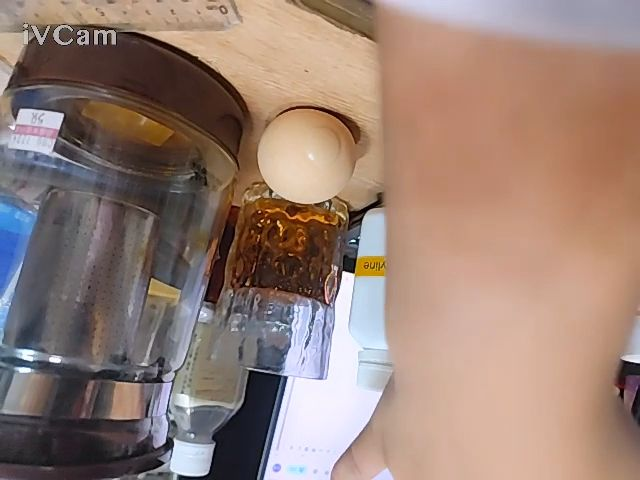

Backed up to Google Drive: /content/drive/MyDrive/data/images/val/photo.jpg

image 1/1 /content/photo.jpg: 480x640 (no detections), 47.6ms
Speed: 11.6ms preprocess, 47.6ms inference, 155.4ms postprocess per image at shape (1, 3, 480, 640)
⚠️ No medicine bottle detected (Failures: 1/3)

[Attempt 2/3] Starting auto-capture in 5 seconds...


<IPython.core.display.Javascript object>

Photo automatically captured and saved to: photo.jpg


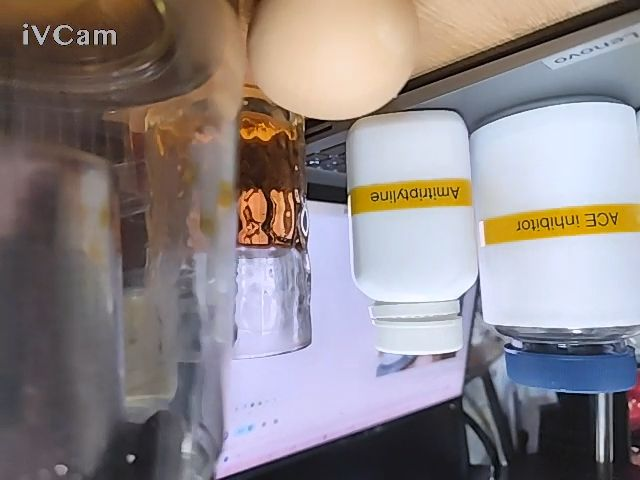

Backed up to Google Drive: /content/drive/MyDrive/data/images/val/photo.jpg

image 1/1 /content/photo.jpg: 480x640 2 medicine_bottles, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 254.9ms postprocess per image at shape (1, 3, 480, 640)

✅ Medicine bottle detected! Details:
Bounding box: (476, 93, 640, 400)
Confidence: 92.2%
Bounding box: (343, 103, 477, 365)
Confidence: 88.9%
Detection process completed successfully!


In [7]:
# Install required libraries
!pip install ultralytics

# Import libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import os
import shutil
import time
from ultralytics import YOLO

# Define auto-capture function with 5-second delay
def auto_capture_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function autoCapture(quality) {
            // Create UI elements
            const div = document.createElement('div');
            const countdown = document.createElement('div');
            countdown.style.fontSize = '24px';
            countdown.style.fontWeight = 'bold';
            countdown.style.color = 'red';
            div.appendChild(countdown);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Show countdown
            let seconds = 5;
            countdown.textContent = `Auto-capturing in ${seconds}...`;

            // Countdown timer
            await new Promise((resolve) => {
                const timer = setInterval(() => {
                    seconds--;
                    countdown.textContent = `Auto-capturing in ${seconds}...`;
                    if (seconds <= 0) {
                        clearInterval(timer);
                        resolve();
                    }
                }, 1000);
            });

            // Capture photo
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('autoCapture({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Set save path
save_folder = '/content/drive/MyDrive/data/images/val'
os.makedirs(save_folder, exist_ok=True)

# Load YOLOv8 model
model = YOLO("/content/drive/MyDrive/info/siou150.pt")

# Initialize counters
max_attempts = 3
failed_attempts = 0

while failed_attempts < max_attempts:
    try:
        # Auto-capture photo with 5-second countdown
        print(f"\n[Attempt {failed_attempts+1}/{max_attempts}] Starting auto-capture in 5 seconds...")
        local_filename = auto_capture_photo()

        if not local_filename:
            raise ValueError("Failed to generate photo file")

        print(f'Photo automatically captured and saved to: {local_filename}')
        display(Image(local_filename))

        # Backup to Google Drive
        try:
            drive_save_path = os.path.join(save_folder, os.path.basename(local_filename))
            shutil.copy(local_filename, drive_save_path)
            print(f'Backed up to Google Drive: {drive_save_path}')
        except Exception as e:
            print(f'Google Drive backup failed: {str(e)}')

        # Run inference
        results = model(local_filename)

        # Process results
        if not results or not results[0].boxes:
            failed_attempts += 1
            print(f"⚠️ No medicine bottle detected (Failures: {failed_attempts}/{max_attempts})")

            if failed_attempts == max_attempts:
                print("\n❌ Failed 3 times. Please check:")
                print("1. Ensure bottle is centered in frame")
                print("2. Adjust camera focus")
                print("3. Clean camera lens")
                print("4. Improve lighting conditions")
            continue

        # Successful detection
        print("\n✅ Medicine bottle detected! Details:")
        for box in results[0].boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0].tolist())
            confidence = box.conf.item()
            print(f"Bounding box: ({x_min}, {y_min}, {x_max}, {y_max})")
            print(f"Confidence: {confidence*100:.1f}%")
        break

    except Exception as err:
        failed_attempts += 1
        print(f"❌ Error occurred: {str(err)} (Failures: {failed_attempts}/{max_attempts})")

        if failed_attempts >= max_attempts:
            print("\n🔴 System stopped: Maximum error count reached")
            break

# Final status check
if failed_attempts >= max_attempts:
    print("\nProcess ended: No valid medicine bottle detected")
else:
    print("Detection process completed successfully!")

In [ ]:

import cv2
import torch

# 1. 載入模型（使用你訓練的藥瓶偵測模型，或預設 yolov8n.pt）
#model = YOLO("yolov8n.pt")  # 替換為你的訓練模型，如 "best.pt"

# 2. 讀取圖片
image_path = "photo.jpg"  # 替換為你的圖片路徑
image = cv2.imread(image_path)
# 4. 解析結果，提取藥瓶的 2D 坐標
for result in results:
    for box in result.boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0]  # 取得邊界框座標
        x_center = (x_min + x_max) / 2  # 計算中心點 x 座標
        y_center = (y_min + y_max) / 2  # 計算中心點 y 座標
        print(f"藥瓶 2D 坐標: ({x_center:.2f}, {y_center:.2f})")

        # 5. 在圖片上標記檢測結果
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.circle(image, (int(x_center), int(y_center)), 5, (0, 0, 255), -1)
        cv2.putText(image, "Medicine Bottle", (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)



藥瓶 2D 坐標: (398.49, 291.92)
藥瓶 2D 坐標: (279.60, 343.41)
藥瓶 2D 坐標: (535.13, 297.46)


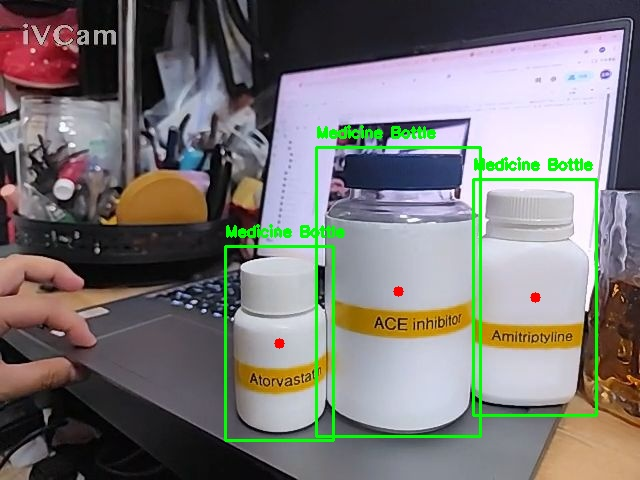

In [ ]:
import cv2
cv2.imwrite("result.jpg", image)
from IPython.display import display
from PIL import Image
display(Image.open("result.jpg"))


ROI 1:


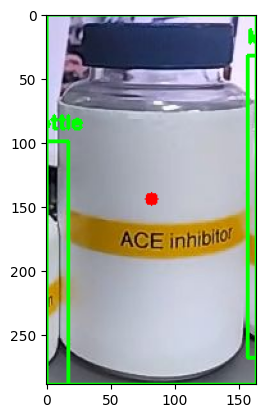

ROI 1:


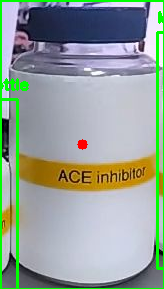

ROI 2:


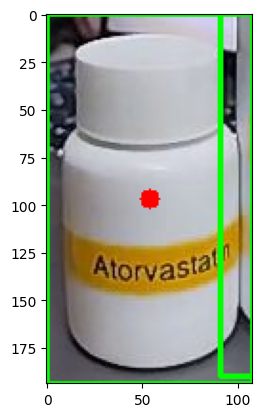

ROI 2:


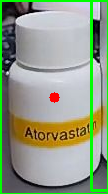

ROI 3:


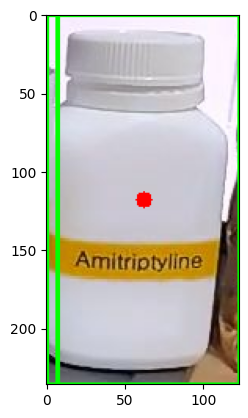

ROI 3:


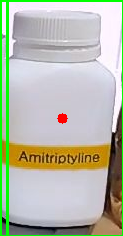

ROI 1:
  边界框坐标: (316, 147, 480, 436)
  中心点坐标: (398.0, 291.5)
------------------------------
ROI 2:
  边界框坐标: (225, 246, 333, 440)
  中心点坐标: (279.0, 343.0)
------------------------------
ROI 3:
  边界框坐标: (473, 179, 596, 415)
  中心点坐标: (534.5, 297.0)
------------------------------


In [ ]:
import cv2
from matplotlib import pyplot as plt

# 假设你已经加载了图像并运行了 YOLOv8 检测
# image 是原始图像，results 是 YOLOv8 的检测结果

# 提取检测框
boxes = results[0].boxes.xyxy.cpu().numpy()

# 遍历每个检测框
for i, box in enumerate(boxes):
    xmin, ymin, xmax, ymax = map(int, box[:4])
    roi = image[ymin:ymax, xmin:xmax]  # 提取 ROI

    # 显示裁剪的 ROI
    print(f"ROI {i+1}:")
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  # OpenCV 是 BGR 格式，matplotlib 需要 RGB
    plt.axis('on')  # 不显示坐标轴
    plt.show()

    # 或者使用 OpenCV 的 cv2_imshow（Colab 专用）
    from google.colab.patches import cv2_imshow
    print(f"ROI {i+1}:")
    cv2_imshow(roi)

# 4. 定义数据结构存储 ROI 信息
rois = []  # 存储所有 ROI 的信息

# 5. 解析结果，提取药瓶的 2D 坐标
for i, result in enumerate(results):
    for j, box in enumerate(result.boxes):
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # 获取边界框坐标

        # 计算中心点坐标
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2

        # 将 ROI 信息存储到字典中
        roi_info = {
            "id": i + 1,  # ROI 编号
            "coordinates": (x_min, y_min, x_max, y_max),  # 边界框坐标
            "center": (x_center, y_center)  # 中心点坐标
        }
        rois.append(roi_info)  # 添加到列表中

if len(rois) == 0:
    print("n ROI")  # 没有检测到任何ROI
else:
    for i, roi in enumerate(rois, 1):  # 使用enumerate获取带序号的迭代
        print(f"ROI {i}:")
        print(f"  边界框坐标: {roi['coordinates']}")
        print(f"  中心点坐标: {roi['center']}")
        print("-" * 30)



In [ ]:
import cv2   #v2
import os

# 假设你已经加载了图像并运行了 YOLOv8 检测
# image 是原始图像，results 是 YOLOv8 的检测结果

# 提取检测框
boxes = results[0].boxes.xyxy.cpu().numpy()

# 定义保存路径
output_dir = "/content/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR"
os.makedirs(output_dir, exist_ok=True)  # 创建文件夹（如果不存在）

# 遍历所有检测框
for i, box in enumerate(boxes):
    xmin, ymin, xmax, ymax = map(int, box[:4])

    # 提取 ROI
    roi = image[ymin:ymax, xmin:xmax]

    # 放大 ROI
    scale_factor = 2  # 放大倍数
    resized_roi = cv2.resize(roi, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # 定义保存路径
    output_filename = f"roi_{i + 1}.jpg"  # 文件名按序号命名
    output_path = os.path.join(output_dir, output_filename)

    # 保存放大后的 ROI
    cv2.imwrite(output_path, resized_roi)
    print(f"ROI {i + 1} 已保存到: {output_path}")

ROI 1 已保存到: /content/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR/roi_1.jpg
ROI 2 已保存到: /content/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR/roi_2.jpg
ROI 3 已保存到: /content/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR/roi_3.jpg


In [ ]:
import cv2#v2
import os
!pip install paddleocr
!pip install paddlepaddle
from paddleocr import PaddleOCR

# 初始化目标ROI列表
wanted_rois = []

# 初始化OCR引擎
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # 设置语言为英文
target_text = "ace inhibitor"  # 目标文字（小写）

# 创建输出目录
output_dir = "/content/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR"
os.makedirs(output_dir, exist_ok=True)

# 遍历所有检测框
for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy(), 1):
    xmin, ymin, xmax, ymax = map(int, box[:4])

    # 提取并放大ROI
    roi = image[ymin:ymax, xmin:xmax]
    resized_roi = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # 保存临时文件
    output_path = os.path.join(output_dir, f"roi_{i}.jpg")
    cv2.imwrite(output_path, resized_roi)

    # OCR识别
    ocr_result = ocr.ocr(output_path, det=True, rec=True)

    # 检查目标文本
    text_found = False
    for line in ocr_result[0]:
        current_text = line[1][0].lower()
        if target_text in current_text:
            text_found = True
            break

    # 只记录包含目标文本的ROI
    if text_found:
        roi_info = {
            "id": i,
            "coordinates": (xmin, ymin, xmax, ymax),
            "center": ((xmin + xmax)//2, (ymin + ymax)//2),
            "ocr_text": current_text  # 记录匹配到的文本
        }
        wanted_rois.append(roi_info)

# 显示最终结果
if not wanted_rois:
    print("n ROI (未检测到目标药品)")
else:
    print(f"找到 {len(wanted_rois)} 个目标ROI:")
    for roi in wanted_rois:
        print(f"""
        ROI {roi['id']}:
        位置: {roi['coordinates']}
        中心点: {roi['center']}
        识别文本: {roi['ocr_text']}
        {'-'*30}""")

# 传递给下一步处理
def process_rois(roi_list):
    if roi_list:
        print("\n正在处理目标区域...")
        for roi in roi_list:
            print(f"处理 ROI{roi['id']} [中心点: {roi['center']}]")
    else:
        print("没有需要处理的目标区域")

process_rois(wanted_rois)

[2025/03/25 13:16:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l